In [ ]:
# Step 1: Install required libraries
!pip install pandas scikit-learn imbalanced-learn tensorflow keras

In [ ]:
# Step 2: Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import cv2

In [ ]:
# Step 3: Load the dataset from Google Drive or upload manually
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [ ]:
# prompt: load from google drive

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
# Example assuming your data is in 'MyDrive/data/train.csv'
# df = pd.read_csv('/content/drive/MyDrive/data/train.csv')


Mounted at /content/drive


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))
# Step 4: Handle missing values (fill missing age values with median)
df['age'].fillna(df['age'].median(), inplace=True)

# Step 5: Encode categorical variables
label_encoder = LabelEncoder()
df['dx'] = label_encoder.fit_transform(df['dx'])

<ipython-input-33-11686aba5015>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)


In [ ]:
# Step 6: Load and preprocess image data
image_size = (300, 300)
image_dir = '/content/drive/MyDrive/skin_disease_dataset/Skin Cancer/Skin Cancer/Skin Cancer'  # Update with the actual path of images
X = []
y = []

for index, row in df.iterrows():
    img_path = os.path.join(image_dir, row['image_id'] + ".jpg")
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalize
        X.append(img)
        y.append(row['dx'])

X = np.array(X)
y = np.array(y)


In [ ]:
# Step 7: Split data into training (70%), testing (20%), and validation (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

In [ ]:
# Step 8: Apply Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [ ]:
# Step 9: Create an EfficientNetB0 model for transfer learning
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model.trainable = True  # Enable fine-tuning
for layer in base_model.layers[:-30]:  # Freeze first 30 layers
    layer.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),  # Improve stability
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.00005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Step 11: Add Learning Rate Scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

In [ ]:
val_datagen = ImageDataGenerator()  # No augmentation for validation
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

history = model.fit(
    train_generator,
    validation_data=val_generator,  # Use generator instead of (X_val, y_val)
    epochs=50,
    batch_size=32,
    callbacks=[lr_scheduler]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 199s 8s/step - accuracy: 0.4614 - loss: 3.1240 - val_accuracy: 0.6667 - val_loss: 1.2581 - learning_rate: 5.0000e-05
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 137s 8s/step - accuracy: 0.5046 - loss: 2.9069 - val_accuracy: 0.6667 - val_loss: 1.4886 - learning_rate: 5.0000e-05
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - accuracy: 0.5218 - loss: 2.2567 - val_accuracy: 0.6667 - val_loss: 1.5877 - learning_rate: 5.0000e-05
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.5722 - loss: 1.9075 - val_accuracy: 0.6667 - val_loss: 1.3401 - learning_rate: 5.0000e-05
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.6221 - loss: 1.5935 - val_accuracy: 0.6667 - val_loss: 1.6030 - learning_rate: 2.5000e-05
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 122s 8s/step - accuracy: 0.5742 - loss: 1.4927 - val_accuracy: 0.6667 - val_loss: 1.4887 - learning_rate: 2.5000e-05
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - accuracy: 0.5898 

In [ ]:
# Step 13: Evaluate on Training data
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))


16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.6599 - loss: 1.2972
Training Accuracy: 66.87%


In [ ]:
# Step 14: Evaluate on Validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6732 - loss: 1.2882
Validation Accuracy: 66.67%


In [ ]:
# Step 15: Evaluate on Testing data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.6950 - loss: 1.2611
Test Accuracy: 67.36%


In [ ]:
model.save("/content/skin_cancer_model.h5")


In [ ]:
from google.colab import files
files.download("/content/skin_cancer_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install tensorflow numpy matplotlib scikit-learn


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd

# Define paths
DATASET_PATH = "/content/dataset.csv"  # Path to your CSV file
IMAGE_DIR = "/content/drive/MyDrive/skin_disease_dataset/Skin Cancer/Skin Cancer/Skin Cancer"  # Path to your images directory
IMG_SIZE = 224  # Image size for CNN model
BATCH_SIZE = 32

# Load images and labels from CSV
def load_data(dataset_path, image_dir):
    df = pd.read_csv(dataset_path)
    images = []
    labels = []
    class_names = df['dx'].unique()  # Assuming 'dx' column contains class labels

    from google.colab import drive
    drive.mount('/content/drive')


    # Get a list of all image files in the directory
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    for index, row in df.iterrows():
        img_path = os.path.join(image_dir, row['image_id'] + ".jpg")

        # Check if the image file exists in the directory
        if os.path.basename(img_path) in image_files:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0  # Normalize pixels to [0,1]
                images.append(img)
                labels.append(row['dx'])  # Use the class label from the CSV
            else:
                print(f"Warning: Could not read image at path: {img_path}")
        else:
            print(f"Warning: Image file not found: {img_path}")

    return np.array(images), np.array(labels), class_names

# Load dataset
images, labels, class_names = load_data(DATASET_PATH, IMAGE_DIR)

# Rest of your code...)


# Split into train & validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Save labels for training script
np.save("y_train.npy", y_train)
np.save("y_val.npy", y_val)

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
)

val_datagen = ImageDataGenerator()  # No augmentation for validation set

# Create TensorFlow generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

print(f"Dataset Ready ✅ | Train Samples: {len(X_train)} | Validation Samples: {len(X_val)}")


Streaming output truncated to the last 5000 lines.
Dataset Ready ✅ | Train Samples: 576 | Validation Samples: 144


Streaming output truncated to the last 5000 lines.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.4081 - loss: 1.7094 - val_accuracy: 0.6667 - val_loss: 1.1911 - learning_rate: 1.0000e-04
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.6341 - loss: 1.2951 - val_accuracy: 0.6667 - val_loss: 1.1530 - learning_rate: 1.0000e-04
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.6434 - loss: 1.2285 - val_accuracy: 0.6667 - val_loss: 1.1515 - learning_rate: 1.0000e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.6894 - loss: 1.1326 - val_accuracy: 0.6667 - val_loss: 1.1509 - learning_rate: 1.0000e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.6597 - loss: 1.2013 - val_accuracy: 0.6667 - val_loss: 1.1505 - learning_rate: 1.0000e-04
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.6486 - loss: 1.2100 - val_accuracy: 0.6667 - val_loss: 1.1509 - learning_rate: 1.0000e-04
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.6555 - loss:

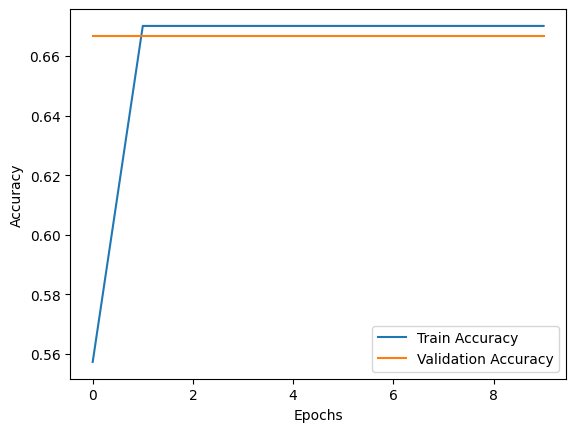

Model Training Complete ✅ | Model Saved as 'skin_cancer_model.h5'


In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
DATASET_PATH = "/content/dataset.csv"  # Path to your CSV file
IMAGE_DIR = "/content/drive/MyDrive/skin_disease_dataset/Skin Cancer/Skin Cancer/Skin Cancer"  # Path to your images directory
IMG_SIZE = 224  # Image size for CNN model
BATCH_SIZE = 32

# Load images and labels from CSV
def load_data(dataset_path, image_dir):
    df = pd.read_csv(dataset_path)
    images = []
    labels = []
    class_names = df['dx'].unique()  # Assuming 'dx' column contains class labels

    # Get a list of all image files in the directory
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    for index, row in df.iterrows():
        img_path = os.path.join(image_dir, row['image_id'] + ".jpg")

        # Check if the image file exists in the directory
        if os.path.basename(img_path) in image_files:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0  # Normalize pixels to [0,1]
                images.append(img)
                labels.append(row['dx'])  # Use the class label from the CSV
            else:
                print(f"Warning: Could not read image at path: {img_path}")
        else:
            print(f"Warning: Image file not found: {img_path}")

    return np.array(images), np.array(labels), class_names

# Load dataset
images, labels, class_names = load_data(DATASET_PATH, IMAGE_DIR)

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # Apply label encoding

# Split into train & validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)


# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
)

val_datagen = ImageDataGenerator()  # No augmentation for validation set

# Create TensorFlow generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = len(np.unique(y_train))  # Fixes the NameError

# Load EfficientNetB0 as base model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model layers

# Custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)  # Multi-class classification

# Compile model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stop, reduce_lr])

# Save trained model
model.save("skin_cancer_model.h5")

# Plot training accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("Model Training Complete ✅ | Model Saved as 'skin_cancer_model.h5'")

In [11]:
# Evaluate the model on training and validation data
train_loss, train_acc = model.evaluate(train_generator, verbose=1)
val_loss, val_acc = model.evaluate(val_generator, verbose=1)

print(f"✅ Training Accuracy: {train_acc:.4f}")
print(f"✅ Validation Accuracy: {val_acc:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.6790 - loss: 1.1354
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6992 - loss: 1.0854
✅ Training Accuracy: 0.6701
✅ Validation Accuracy: 0.6667


In [17]:
pip install seaborn scikit-learn matplotlib


In [20]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
DATASET_PATH = "/content/dataset.csv"
IMAGE_DIR = "/content/drive/MyDrive/skin_disease_dataset/Skin Cancer/Skin Cancer/Skin Cancer"
IMG_SIZE = 224
BATCH_SIZE = 32
TEST_DATASET_PATH = "/content/dataset.csv"  # Use the same dataset for testing for now

# Load images and labels from CSV
def load_data(dataset_path, image_dir):
    df = pd.read_csv(dataset_path)
    images = []
    labels = []
    class_names = df['dx'].unique()
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    for index, row in df.iterrows():
        img_path = os.path.join(image_dir, row['image_id'] + ".jpg")
        if os.path.basename(img_path) in image_files:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0
                images.append(img)
                labels.append(row['dx'])
            else:
                print(f"Warning: Could not read image at path: {img_path}")
        else:
            print(f"Warning: Image file not found: {img_path}")  # Closing " added
    return np.array(images), np.array(labels), class_names

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
